# 0. Libraries Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from dask import dataframe as dd
import seaborn as sns
random.seed(100)


from sklearn.preprocessing import LabelEncoder, OneHotEncoder,LabelBinarizer
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics 

import time

from tqdm.notebook import tqdm
import itertools

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import MaxPooling1D, Conv1D, Activation,Dropout,Input, Embedding, Dot, Reshape, Dense, Masking, Flatten, LSTM,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

In [2]:
# importing the tensorflow package and check the version of tensorflow
import tensorflow as tf 
print('- tf_version : ',tf.__version__)

#Check if it's built with cuda (it has to be True)
print('- build with cuda : ',tf.test.is_built_with_cuda())

#Check if there is a GPU available 
print('- gpu available : ',tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

#Display the list of available devices
from tensorflow.python.client import device_lib
print('- GPU used : \n',device_lib.list_local_devices())

- tf_version :  2.0.0
- build with cuda :  True
- gpu available :  True
- GPU used : 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1056337111817021613
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1422723891
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5780469179031727984
physical_device_desc: "device: 0, name: GeForce MX250, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# 1. Importing the dataset

In [7]:
#Path to the data
data_path='D:/Google Drive/Cours/MA2/TFE/Project/(actual)tracking_project/Data/url_properties.csv'

#Column to use from the .csv file + dtype for each column
used_columns=['url', 'scheme', 'netloc', 'path', 'domain', 'is_tracking','type','mime_type','domains']
used_dtype={'url': 'str',
            'scheme': 'str', 
            'netloc': 'str', 
            'path': 'str', 
            'is_tracking':'bool'}

In [ ]:
#Loading the dataset using Dask (library for parallelization)
df_tracking = dd.read_csv(data_path,
                 sep="\t",
                 usecols=used_columns,
                 error_bad_lines=False,
                 engine='c',
                 blocksize=1000000)

In [ ]:
#Loading the dataset using Panda
df_tracking = pd.read_csv(data_path,
                 sep="\t",
                 #usecols=used_columns,
                 error_bad_lines=False,
                 engine='c')

In [ ]:
#if used_columns not used --> drop not used columns
df_tracking=df_tracking.drop(columns=['id','port', 'params','fragment','fragment','password','username']).compute()

The below cell is the one I usually use because it only loads the URLs with the label

In [48]:
#data_path='D:/Google Drive/Cours/MA2/TFE/Project/(actual)tracking_project/Data/url_tracking_list_and_blockers.csv'
data_path='D:/Google Drive/Cours/MA2/TFE/Project/(actual)tracking_project/Data/url_tracking_list_and_blockers_modified.csv'

used_columns=['url', 'is_tracking','mime_type']
used_dtype={'url': 'str',
            'is_tracking':'float'}

df_tracking = pd.read_csv(data_path,
                 sep="\t",
                 usecols=used_columns,
                 dtype=used_dtype,
                 error_bad_lines=False,
                 engine='c')

#Drop columns if NA inside
df_tracking=df_tracking.dropna()

In [4]:
df_tracking

url   mime_type  \
0                       https://www.google.com/?gws_rd=ssl   text/html   
1        https://www.google.com/images/branding/googlel...   image/png   
2        https://consent.google.com/status?continue=htt...   text/html   
3        https://ssl.gstatic.com/gb/images/i1_1967ca6a.png   image/png   
4        https://www.google.com/images/searchbox/deskto...  image/webp   
...                                                    ...         ...   
5231223  https://www.capetownetc.com/wp-content/uploads...  image/jpeg   
5231224  https://www.capetownetc.com/wp-content/uploads...  image/jpeg   
5231225  https://www.capetownetc.com/wp-content/uploads...  image/jpeg   
5231226  https://www.capetownetc.com/wp-content/uploads...   image/png   
5231227  https://www.capetownetc.com/wp-content/uploads...  image/jpeg   

         is_tracking  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...              ...  
5231223          0.0  
5231224          0.0  
5231225          0.0  
5231226          0.0  
5231227          0.0  

[5231228 rows x 3 columns]

# 2. Dataset Preprocessing

### (Optional) 2.1. Computing the URL Parameters

Here is the section I use to compute the parameters of the URLs and then store it in a .csv file

In [ ]:
columns_for_reduction=["url", "path",'scheme','netloc']
def url_reduction(columns_for_reduction,df_tracking):

    data_url=df_tracking[columns_for_reduction[1:]]
    url_reducted=list(df_tracking[columns_for_reduction[0]])
    
    for column in tqdm(columns_for_reduction[1:]):
        url_reducted = [a.replace(str(b), '').strip() for a, b in zip(url_reducted, data_url[column])]
        print(url_reducted[0])
    return url_reducted

In [ ]:
time_start = time.time()
url_reducted=url_reduction(columns_for_reduction,df_tracking)
print('Reduction done! Time elapsed: {} minutes'.format((time.time()-time_start)/60))

In [ ]:
df_reducted=list(zip(url_reducted, df_tracking['is_tracking']))

In [ ]:
import csv

with open("url_reducted_dataset.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(df_reducted)

##### 2.1.A Load URL parameters dataset

In [ ]:
data_path='url_reducted_dataset.csv'

df_tracking = dd.read_csv(data_path,
                          sep=",",
                          header=None,
                          names=['url_parameters', 'is_tracking'],
                          error_bad_lines=False,
                          engine='python',
                          blocksize=1000000)

### 2.2. Preprocessing on the labels

In [20]:
df_tracking.head()

url   mime_type  is_tracking
0                 https://www.google.com/?gws_rd=ssl   text/html          0.0
1  https://www.google.com/images/branding/googlel...   image/png          0.0
2  https://consent.google.com/status?continue=htt...   text/html          0.0
3  https://ssl.gstatic.com/gb/images/i1_1967ca6a.png   image/png          0.0
4  https://www.google.com/images/searchbox/deskto...  image/webp          0.0

In [ ]:
#Load the labels into a numpy array
time_start = time.time()
y=np.asarray(df_tracking['is_tracking']).astype('bool')

#Transform the labels depending on the value (binarization)
lb = LabelBinarizer()
y=lb.fit_transform(y)
y=utils.to_categorical(y)
print('Dataset Loading done! Time elapsed: {} minutes'.format((time.time()-time_start)/60))

### 2.3. Preprocessing on the URLs

In [50]:
#Load the URLs into a numpy array
time_start = time.time()
X=np.array(df_tracking['url'])
print('Dataset Loading done! Time elapsed: {} minutes'.format((time.time()-time_start)/60))

Dataset Loading done! Time elapsed: 0.001668266455332438 minutes


In [51]:
#Separate each URL into single elements
for idx,url in tqdm(enumerate(X)):
    letters=[letter for letter in url]
    letters=np.asarray(letters)
    X[idx]=(letters)

#### 2.3.A. Tokenization

In [ ]:
import json

#Here, I associate a number for each symbol contained in the URLs
time_start = time.time()
le=LabelEncoder()
le.fit(np.concatenate(X, axis=0))
X=[le.transform(elem) for elem in X]
print('Label Encoding done! Time elapsed: {} minutes'.format((time.time()-time_start)/60))

dict_label=dict(zip(le.classes_, [i for i in range(0,len(le.classes_))]))

#I store the dictionary Symbol/Value to a .json file
with open('dict_url_raw.json', 'w') as f:
    json.dump(dict_label, f)

In [52]:
import json

#If the dictionary has already been stored, load the dictionary
with open('dict_url_raw.json') as f:
    dict_label = json.load(f)
#REMOVE THE 0 FOR THE PADDING
for key, val in dict_label.items():
    if val==0:
        dict_label[key]=len(dict_label)

In [53]:
#Apply the dictionary to the URLs
for idx,letters in tqdm(enumerate(X)):
    if isinstance(letters[0], str):
        X[idx]=np.vectorize(dict_label.get)(letters)

#### 2.3.B. Padding

In [54]:
time_start = time.time()
X = tf.keras.preprocessing.sequence.pad_sequences(X,
                                                 maxlen=200,
                                                 padding='pre',
                                                    truncating='pre',
                                                 dtype='int32')
print('Padding done! Time elapsed: {} minutes'.format((time.time()-time_start)/60))

Padding done! Time elapsed: 0.7300850987434387 minutes


### 2.4. Train / Validation / Test splitting

In [55]:
#Here it is an optional line, it has to be used if you want to keep the index on the data after the splitting (for t-SNE mainly)
y = pd.Series(y.argmax(axis=1))

In [56]:
#Splitting the data into different arrays
time_start = time.time()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=1/3, random_state=42)
print('Splitting done! Time elapsed: {} minutes'.format((time.time()-time_start)/60))
print('X_train.shape : ',X_train.shape)
print('X_val.shape : ',X_val.shape)
print('X_test.shape : {}\n'.format(X_test.shape))
print('y_train.shape : ',y_train.shape)

Splitting done! Time elapsed: 1.3169766664505005 minutes


"print('X_train.shape : ',X_train.shape)\nprint('X_val.shape : ',X_val.shape)\nprint('X_test.shape : {}\n'.format(X_test.shape))\nprint('y_train.shape : ',y_train.shape)"

In [32]:
#Optional line, to use if you want to train a RNN
X_train = np.expand_dims(X_train, 2)
X_val = np.expand_dims(X_val, 2)
X_test = np.expand_dims(X_test, 2)

# 3. Model Training

In [28]:
#RNN
def create_model(num_labels=2, dropout_rate=0.3, learning_rate=0.0001):
       
    model = Sequential()
    model.add(Masking(mask_value=0.,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(Embedding(input_dim=X_train_padded.shape[1], mask_zero=True))
    model.add(LSTM(128))
    #model.add(Flatten())
    #model.add(Dense(512, activation='relu'))
    model.add(Dense(num_labels, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'], 
                  optimizer=Adam(lr=learning_rate))
    
    return model

In [ ]:
#DNN without embedding (Masking indicates to the model the zeros of the padding)
def create_model(num_labels=2, dropout_rate=0.3, learning_rate=0.0001):
       
    model = Sequential()
    model.add(Masking(mask_value=0.,input_shape=(X_train.shape[1], X_train.shape[2])))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_labels, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'], 
                  optimizer=Adam(lr=learning_rate))
    
    return model

In [ ]:
#CNN with embeddings
def create_model(num_labels=2, dropout_rate=0.3, learning_rate=0.0001):
       
    model = Sequential()
    model.add(Embedding(input_dim=len(dict_label)+1, output_dim=32,mask_zero=True, input_length=X_train.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu',padding='valid'))
    model.add(Conv1D(filters=128, kernel_size=4, activation='relu',padding='valid'))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu',padding='valid'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_labels, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'], 
                  optimizer=Adam(lr=learning_rate))
    
    return model

In [ ]:
#DNN with embedding
def create_model(num_labels=2, dropout_rate=0.3, learning_rate=0.0001):
       
    model = Sequential()
    model.add(Embedding(input_dim=len(dict_label)+1, output_dim=32,mask_zero=True, input_length=X_train.shape[1]))
    model.add(Flatten())
    '''model.add(Dense(2048, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rate))'''
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_labels, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'], 
                  optimizer=Adam(lr=learning_rate))
    
    return model

In [ ]:
#EarlyStopper stops the training when no improvement is made and store the best model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

def EarlyStopper():
    #Definition of the EarlyStopper that can stop the training when there's no improvements
    stopper=EarlyStopping(monitor='val_loss',
                         min_delta=0.005,
                         patience=5,
                         verbose=0,
                         mode='auto')
    #Save the best model in a file
    ckpt_save=os.path.join('.', './url_models/DNN_post_truncated_list.h5')

    checkpoint=ModelCheckpoint(ckpt_save, monitor='val_loss',verbose=1, save_best_only=True, mode='auto')
    callback_list=[checkpoint, stopper]
    
    return callback_list

In [ ]:
#Create the model chosen above
model=create_model(num_labels=2, dropout_rate=0.5, learning_rate=0.0001)

In [ ]:
model.summary()

In [ ]:
#Training of the model
history=model.fit(X_train, y_train,
                  validation_data=(X_val,y_val),
                  epochs=70, 
                  batch_size=1024, 
                  verbose=1,
                  callbacks=EarlyStopper())             

In [21]:
#Load the best model (don't forget to adapt the name)
model=load_model('./url_models/DNN_pre_truncated_list.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


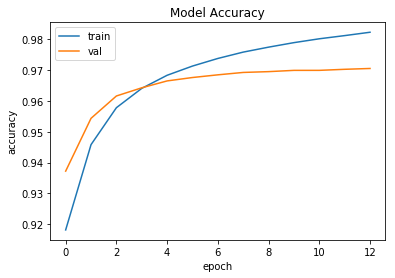

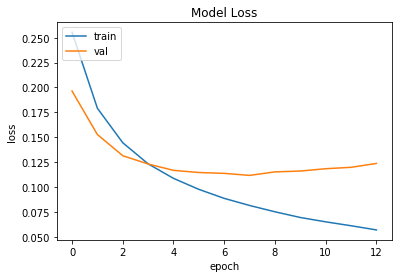

In [22]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 4. Model Evaluation

In [23]:
print('Test on {} features'.format(X_test.shape[1]))
target_names=['No tracking','tracking']
y_pred=model.predict(X_test)
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
classification_report_tmp=classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names)

score = model.evaluate(X_test, y_test, verbose=False) 
print('Test loss score: ', score[0])    #Loss on test
print('Test accuracy: ', score[1])

print(matrix)
print(classification_report_tmp)

Test on 200 features
Test loss score:  0.11229738046786887
Test accuracy:  0.9691351
[[691776   3607]
 [ 20635  69405]]
              precision    recall  f1-score   support

 No tracking       0.97      0.99      0.98    695383
    tracking       0.95      0.77      0.85     90040

    accuracy                           0.97    785423
   macro avg       0.96      0.88      0.92    785423
weighted avg       0.97      0.97      0.97    785423



### Test Only on jquery

In [17]:
a=df_tracking.index[df_tracking['url'].str.contains('jquery') == True].tolist()

In [ ]:
a=df_tracking.index[df_tracking['url'].str.contains('jquery') == True].tolist()

In [30]:
y_test_jquery=[]
X_test_jquery=[]
i=0
for y_index,y_value in tqdm(y_test.items()):
    if y_index in a:
        X_test_jquery.append(X_test[i])
        y_test_jquery.append(y_value)
    i+=1
X_test_jquery=np.asarray(X_test_jquery)

In [31]:
y_test_jquery=np.asarray(y_test_jquery)

In [20]:
print(len(X_test_jquery))
print(len(y_test_jquery))

46382
46382


In [26]:
X_test_jquery=np.asarray(X_test_jquery)

In [21]:
model=load_model('./url_models/DNN_post_truncated_list.h5')

In [36]:
print('Test on {} features'.format(X_test.shape[1]))
target_names=['No tracking','tracking']
y_pred=model.predict(X_test_jquery)
matrix = metrics.confusion_matrix(y_test_jquery, y_pred.argmax(axis=1))
classification_report_tmp=classification_report(y_test_jquery, y_pred.argmax(axis=1), target_names=target_names)

print(matrix)
print(classification_report_tmp)

Test on 200 features
[[44635    23]
 [  592  1132]]
              precision    recall  f1-score   support

 No tracking       0.99      1.00      0.99     44658
    tracking       0.98      0.66      0.79      1724

    accuracy                           0.99     46382
   macro avg       0.98      0.83      0.89     46382
weighted avg       0.99      0.99      0.99     46382



### Get list of misclassified URL's

In [13]:
print('Test on {} features'.format(X_test.shape[1]))
target_names=['No tracking','tracking']
y_pred=model.predict(X_test)
matrix = metrics.confusion_matrix(y_test, y_pred.argmax(axis=1))
classification_report_tmp=classification_report(y_test, y_pred.argmax(axis=1), target_names=target_names)

Test on 200 features


In [16]:
print(classification_report_tmp)

              precision    recall  f1-score   support

 No tracking       0.97      0.99      0.98   1185614
    tracking       0.87      0.73      0.80    148750

    accuracy                           0.96   1334364
   macro avg       0.92      0.86      0.89   1334364
weighted avg       0.96      0.96      0.96   1334364



In [22]:
def to_df_misclassified(df_size,X_test, y_test, model, df_tracking):
    
    y_pred=model.predict(X_test)
    y_pred = pd.Series(y_pred.argmax(axis=1),index=y_test.index)

    well_classified = (y_test == y_pred)
    index=well_classified[well_classified==False].index

    false_url=df_tracking['url'].compute().reset_index()
    false_url=false_url.drop(columns='index')

    domains=np.array(df_tracking['domains'].compute())

    df_wrong_url = pd.DataFrame(false_url.loc[index[:df_size]])
    df_wrong_url['true_label']=y_test[index[:df_size]]
    df_wrong_url['predicted_label']=y_pred[index[:df_size]]
    df_wrong_url['domains']=domains[index[:df_size]]

    #df_wrong_url.insert(1, "true_label", y_test[index[:df_size]], True)
    #df_wrong_url.insert(2, "predicted_label", y_pred[index[:df_size]], True)
    #df_wrong_url.insert(3, "domains", domains[index[:df_size]], True)

    return df_wrong_url

In [ ]:
df_wrong_url=to_df_misclassified(len(X_test),X_test, y_test, model, df_tracking)

In [11]:
df_wrong_url=to_df_misclassified(len(X_test),X_test, y_test, model, df_tracking)

df_wrong_url=df_wrong_url.sort_values(by=['domains'])

In [ ]:
df_wrong_url.head()

In [19]:
with open('misclassified_url_200.csv','w') as write_txt:
    write_txt.write(df_wrong_url.iloc[-200:].to_csv(sep=',', index=False, header=True))

### Test on padding

In [ ]:
well_classified = y_test.argmax(axis=1) == y_pred.argmax(axis=1)
unique, counts = np.unique(well_classified, return_counts=True)
print(dict(zip(unique, counts)))
dict(zip(['Bad Pred','Good Pred'], counts))

{False: 54921, True: 1266100}


{'Bad Pred': 54921, 'Good Pred': 1266100}

In [ ]:
padded=[]
for elem in tqdm(X_test):
    if elem[0]!=0:
        padded.append(0)
    else:
        padded.append(1)
padded=np.asarray(padded)
padded=padded.astype('bool')

In [ ]:
padded_and_predict=[]
for pred, pad in zip(well_classified,padded):
    if pred==False and pad==False:
        padded_and_predict.append(1)
print('There are {} padded AND bad predicted elements'.format(len(padded_and_predict)))

There are 1557 padded AND bad predicted elements


# 5. Visualization

### Plot wrong prediction

In [57]:
model=load_model('./url_models/DNN_pre_list_and_blockers_modified.h5')

In [58]:
y_pred=model.predict(X_test[:50000])

In [59]:
y_test_b=utils.to_categorical(np.asarray(y_test))

In [60]:
limit=50000
label_pred=[]
for pred, label in tqdm(zip(y_pred.argmax(axis=1)[:limit], y_test_b.argmax(axis=1)[:limit])):
    if pred==label:
        if label==0:
            label_pred.append('True Negative') 
        if label==1:
            label_pred.append('True Positive') 
    else :
        if label==0:
            label_pred.append('False Positive') 
        if label==1:
            label_pred.append('False Negative')

In [61]:
model_prediction = Model(inputs=model.input, outputs=model.layers[-3].output)
X_emb=model_prediction.predict(X_test[:50000])

In [62]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=32, verbose=2)
x_tsne = tsne.fit_transform(X_emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 4.526s...
[t-SNE] Computed neighbors for 50000 samples in 55.919s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

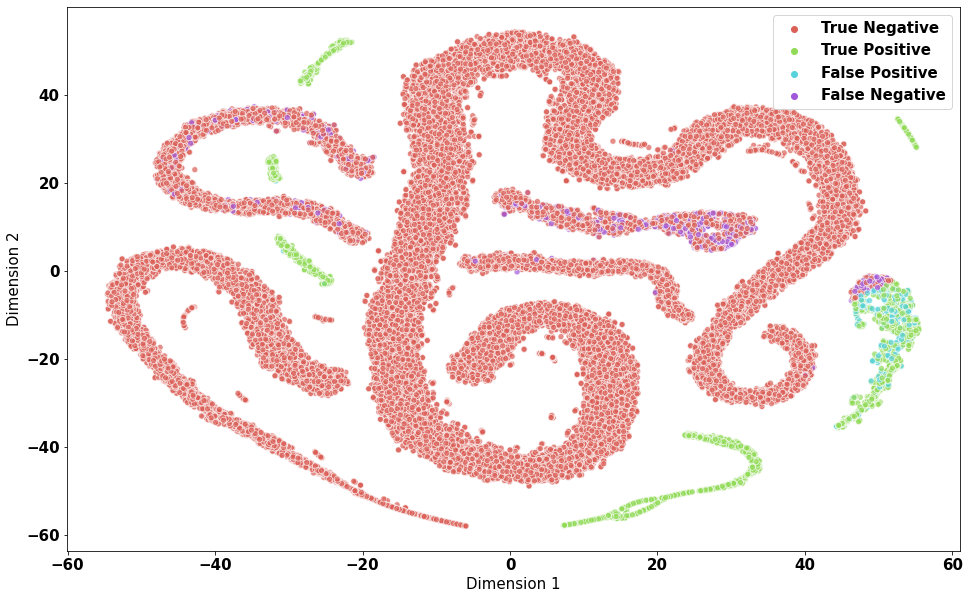

In [63]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)


plt.figure(figsize=(16,10))
sns.scatterplot(
    x=x_tsne[:,0], y=x_tsne[:,1],
    hue=label_pred,
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.7
)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')


plt.savefig('./tsne_layers[-3]_wc_or_bc_final_pre_list_and_blockers_modified.png')

### t-SNE plot depending on the type

In [39]:
model_prediction = Model(inputs=model.input, outputs=model.layers[-3].output)
X_emb=model_prediction.predict(X_test[:50000])

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=32, verbose=2)
x_tsne = tsne.fit_transform(X_emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 5.449s...
[t-SNE] Computed neighbors for 50000 samples in 60.189s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

In [64]:
df_tsne=y_test[:50000].to_frame(name="true_label")
df_tsne['tsne_1'] = x_tsne[:,0]
df_tsne['tsne_2'] = x_tsne[:,1]
#df_tsne=df_tsne.sample(n = 50000) 

In [65]:
y_pred=model.predict(X_test[:50000])
df_tsne['predicted_label']=y_pred.argmax(axis=1)
df_tsne['Good_classification']= y_test[:50000]==y_pred.argmax(axis=1)

In [67]:
mime_type=df_tracking['mime_type'].to_frame(name="mime_type")
mime_type=mime_type.reset_index(drop=True)
df_tsne=df_tsne.join(mime_type)

In [ ]:
mime_type_keep=df_tsne['mime_type'].value_counts()[:10].index
mime_type_keep=mime_type_keep.astype('str')

In [ ]:
df_tsne=df_tsne.join(df_tracking)

In [46]:
df_tsne.head()

true_label     tsne_1     tsne_2  predicted_label  \
3396228           0 -17.939020  -5.482080                0   
1208772           0   9.423374 -40.039673                0   
2196626           0 -32.516014  26.049845                0   
1903138           0  34.790394  11.613661                0   
2919175           0  -1.512333  28.987268                0   

         Good_classification                 mime_type  
3396228                 True  application/x-javascript  
1208772                 True                image/jpeg  
2196626                 True                 image/png  
1903138                 True                 image/png  
2919175                 True           text/javascript

In [68]:
Image_group = ["image/png","image/jpeg","image/webp","image/svg+xml","image/gif"]
JavaScript_group = ["application/javascript","application/x-javascript","text/javascript"] 
HTML_group = ["text/html"]
CSS_group = ["text/css"]

for i, row in df_tsne.iterrows():
    ifor_val = str(row['mime_type'])
    if ifor_val in Image_group:
        ifor_val = 'Image'
    elif ifor_val in JavaScript_group:
        ifor_val = 'Javascript'
    elif ifor_val in HTML_group:
        ifor_val = 'HTML'
    elif ifor_val in CSS_group:
        ifor_val = 'CSS'
    else:
        ifor_val = 'other'
    df_tsne.at[i,'mime_type'] = ifor_val

In [45]:
df_tsne['mime_type'].value_counts()

Image         30223
Javascript     9666
CSS            4313
other          3756
HTML           2042
Name: mime_type, dtype: int64

In [69]:
le=LabelEncoder()
le.fit(df_tsne['mime_type'].astype(str))
df_tsne['encoder_mime_type']=le.transform(df_tsne['mime_type'].astype(str))
dict_mime_type=dict(zip(le.classes_, [i for i in range(0,len(le.classes_))]))

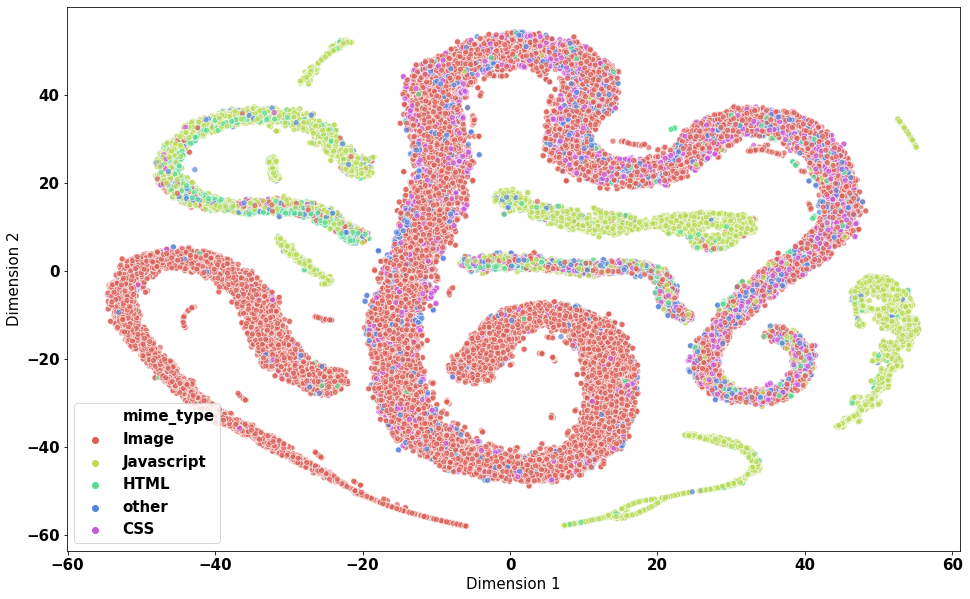

In [70]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=df_tsne['tsne_1'], y=df_tsne['tsne_2'],
    hue=df_tsne['mime_type'],
    palette=sns.color_palette("hls", len(le.classes_)),
    legend='full',
    alpha=0.7
)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig('./tsne_layers[-3]_custom_type_pre_list_and_blockers_modified.png')

### Patterns inside URL

In [ ]:
X_url=np.array(df_tracking['url'])
in_X=[]

for string_url in tqdm(X_url):
    if 'utm' in string_url:
        in_X.append(True)
    else:
        in_X.append(False)

#### Export embedding for Embedding Projector Use

In [ ]:
df_url_weights=pd.DataFrame(data=X_emb.astype('float32'))

In [ ]:
df_url_weights=df_url_weights.sample(frac =.05) 

In [ ]:
df_metadata=pd.DataFrame(columns=['url','type','mime_type','is_tracking','prediction'])
df_metadata['url']=df_tracking['url']
df_metadata['url']=df_metadata['url']

df_metadata['type']=df_tracking['type']

df_metadata['mime_type']=df_tracking['mime_type']

df_metadata['is_tracking']=df_tracking['is_tracking']

df_metadata['prediction']=in_X

In [ ]:
df_metadata=df_metadata.loc[df_url_weights.index]

In [ ]:
w_filenameTSV = './light_url_weights.tsv'


with open(w_filenameTSV,'w') as write_tsv:
    write_tsv.write(df_url_weights.to_csv(sep='\t', index=False, header=False))

In [ ]:
w_filenameTSV_meta = './light_meta_url_weights.tsv'
with open(w_filenameTSV_meta,'w') as write_tsv:
    write_tsv.write(df_metadata.to_csv(sep='\t', index=False,header=True))

# Autoencoders

In [ ]:
import keras.backend as K
from tensorflow.keras.layers import Lambda

def cropOutputs(x):

    #x[0] is decoded at the end
    #x[1] is inputs
    #both have the same shape

    #padding = 1 for actual data in inputs, 0 for 0
    padding =  K.cast( K.not_equal(x[1],0), dtype=K.floatx())
        #if you have zeros for non-padded data, they will lose their backpropagation

    return x[0]*padding

In [ ]:
input_size = X_train.shape[1]
hidden_size = 512
code_size = 128

input_img = Input(shape=(input_size,))
#mask_1 = Masking(mask_value=0.,input_shape=(X_train.shape[1],))(input_img)
mask_1 = Embedding(input_dim=len(dict_label)+1, output_dim=32,mask_zero=True, input_length=X_train.shape[1])(input_img)
mask_1_1 = Flatten()(mask_1)

hidden_1 = Dense(hidden_size, activation='relu')(mask_1_1)
hidden_1_1 = Dense(hidden_size/2, activation='relu')(hidden_1)

code = Dense(code_size, activation='relu', name="bottleneck")(hidden_1_1)

hidden_2_3 = Dense(hidden_size/2, activation='relu')(code)
hidden_2 = Dense(hidden_size, activation='relu')(hidden_2_3
                                                )
output_img_0 = Dense(input_size, activation='relu')(hidden_2)
#output_img_1 = Lambda(cropOutputs,output_shape=input_size)([output_img_0,input_img])



In [ ]:
autoencoder = Model(input_img, output_img_0)
autoencoder.compile(optimizer=Adam(lr=0.0001),loss=tf.keras.losses.MeanSquaredError())#, loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=2)
autoencoder.save('./autoencoder_models/autoencoder_128.h5')

Train on 2682071 samples
Epoch 1/2
2682071/2682071 [==============================] - 627s 234us/sample - loss: 20.4229
Epoch 2/2
2682071/2682071 [==============================] - 621s 232us/sample - loss: 19.1552


In [ ]:
autoencoder=load_model('./autoencoder_models/autoencoder_128.h5')

In [ ]:
def reverse_url(url_int):
    url_int=np.squeeze(url_int)
    url_int=url_int[url_int != 0]
    inv_dict_label = {v: k for k, v in dict_label.items()}
    url_s=[inv_dict_label.get(letter) for letter in url_int]
    url_s=''.join(url_s)
    return url_s

In [ ]:
pred

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 68, 78, 79, 74, 78,
        23, 13, 13, 75, 67, 71, 68, 74, 10, 68, 64, 81, 11, 79, 81, 12,
        68, 72, 59, 65, 64, 77, 11, 67, 78, 71, 71, 18, 70, 79, 73, 62,
        71, 73, 78, 64, 10, 75, 72, 66]])

In [ ]:
pred=autoencoder.predict(np.expand_dims(X_test[0], 0))
pred=pred.astype('int')
pred=reverse_url(pred)
print('Original url : \n{}'.format(reverse_url(X_test[:1])))
print('Decoded url : \n{}'.format(pred))

Original url : 
https://pilio.idv.tw/images/html5ltocloud.png
Decoded url : 
istos:00phlio-iev.tv/im`fer.hsll5ktnclnse-pmg


In [ ]:
encoder=Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)

In [ ]:
X_auto_32=encoder.predict(X_train[:100000])

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=32, verbose=2)
x_auto = tsne.fit_transform(X_auto_32)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 7.501s...
[t-SNE] Computed neighbors for 100000 samples in 2856.926s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional prob

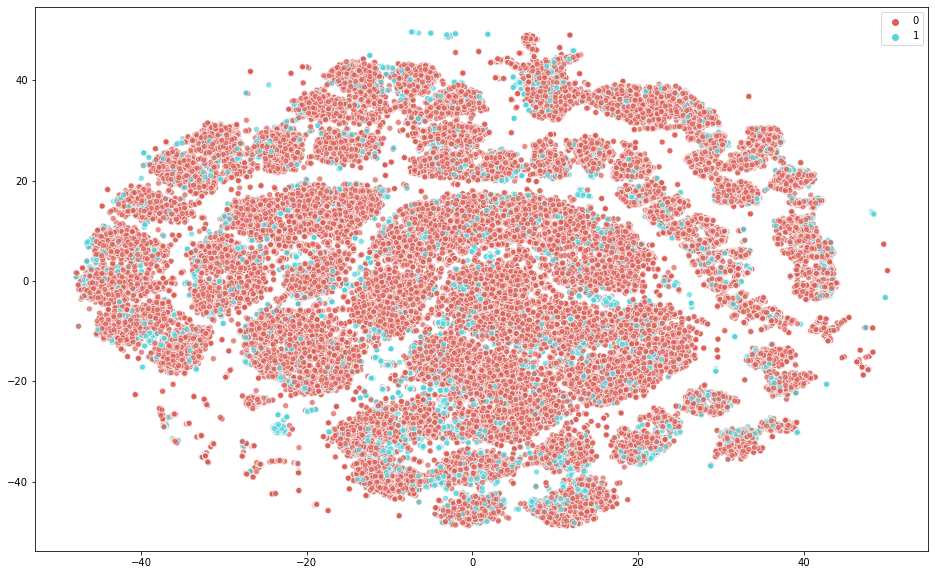

In [ ]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=x_auto[:,0], y=x_auto[:,1],
    hue=y_train[:100000].argmax(axis=1),
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.7
)
plt.savefig('./autoencoder.png')